In [10]:
import libsparse as sp
import matplotlib.pyplot as plt

sparse matrices
===============
***
Motivation
----------
Sparse matrices are matrices that are mostly empty i.e. zeros.

They appear frequently when solving physics problmes, such as in the PDE of a linear chain with 6 elements.

The Differential Equation describing these these systems is called *Hooke's Law*:
$-\ddot{x}=\mathbf{\kappa} x$

In this case $\kappa$ is a matrix containing the spring coefficients acting on each element.

$$
\kappa =
\begin{pmatrix}
2 & -1 & 0 & 0 & 0 & 0\\
-1 & 2 & -1 & 0 & 0 & 0\\
0 & -1 & 2 & -1 & 0 & 0\\
0 & 0 & -1 & 2 & -1 & 0\\
0 & 0 & 0 & -1 & 2 & -1\\
0 & 0 & 0 & 0 & -1 & 2
\end{pmatrix}
$$

As one can see, most of the elements in this matrix are zero.

In these type of problems and in many more, these matrices can get very large and memory intensive. We therefore need a way of working with these low density matrices in a memory efficient way.

The solution is to not store the redundant zeros.

***
Storage scheme
---------------
Not storing the zeros can be done with a number of different strategies:

- **C**ompressed **S**parse **R**ow     (CSR)
- **C**ompressed **S**parse **C**olumn  (CSC)
- **Li**st of **L**ists                 (LIL)
- **Coo**rdinate List                   (COO)
- ...

In this project we will focus on the CSR format.

The CSR format consists of 3 lists:

|      | 0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  8 |  9 |
|:----:|--:|---:|---:|---:|---:|---:|---:|---:|---:|---:|
| AVAL | 2 | -1 | -1 |  2 | -1 | -1 |  2 | -1 | -1 |  2 |
| JCOL | 1 |  2 |  1 |  2 |  3 |  2 |  3 |  4 |  3 |  4 |
| IROW | 0 |  2 |  5 |  8 | 10 |

- AVAL : the values
- JCOL : the index in the matrix where the value from AVAL belongs
- IROW : these are the indices of AVAL or JCOL where a new row begins


***
## Our Project


The task of our project is to implement the storage scheme and necessary mathmatical operations to solve linear systems of equations.
In order to achieve this and as an expansion of this task, our aim was to create a data object which can be used just as seamless as the `scipy.sparse` object.

We therefore needed to develop a class which can be given a standard numpy array and constructs CSR lists as well as providing methods like addition subtraction and mulitplication. These should work on these lists without creating a full-size `numpy.ndarray`.

In addition we devoleped a class to represent linear systems and which implements different methods of solving.

Creating the sparse object with an ndarray:

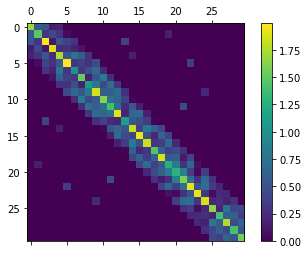

<sparse matrix of shape (30, 30) and sparsity 0.71>

In [11]:
array=sp.random_banded(30,4)

a=sp.sparse(array)
a.show()
a

The instantiated object defines the following attributes `['density', 'shape', 'T', 'CSR', 'N']` of which N is only defined for square matrices, as the dimensionality would be ambiguous.

To make these objects actually useful, we need to implement the `__getitem__` and `__setitem__` method.

These methods make the object subscribtable which makes them a lot more useful.

In [12]:
print("pre ", a[1,1])
a[1,1] = 2
print("post ",a[1,1])

pre  1.484719140080463
post  2.0


Using these methods now greatly simplifiess the more complicated methods such as `__add__`, `__sub__` and `__matmul__`.

We can now just iterate over both array dimensions and do not need to worry about the CSR lists.
This, however, has implications about performance of the code, which we will further discuss in [Optimization](Optimization).

As mentioned previously the data object created by us can handle basic mathmatic operations such as addition, subtraction and matix multiplication as well as transposition.

<!-- Jupyter stinkt -->
<!-- .py >> .ipynb -->

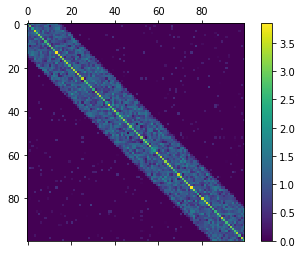

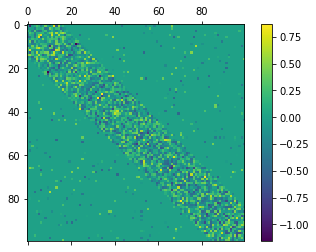

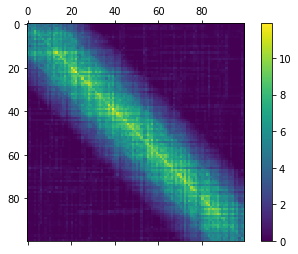

In [13]:
a = sp.sparse(sp.random_banded(100,15))
b = sp.sparse(sp.random_banded(100,15))

add = a + b
sub = a - b
mul = a @ b

add.show()
sub.show()
mul.show()

With algebraic operations taken care of, we can now start to solve linear systems of equations using the `linsys` class. <br>
A `linsys` object can be initialised by passing it a matrix and a target vector of a linear system, where the matrix needs to be either of type `sp.sparse` or `np.ndarray`.<br>
The target vector needs to be a 1-D `list` or `np.ndarray` of the same length as the matrix dimension.<br>
Once the linear system is created, it's still possible to get the components using the attributes `linsys.target_vector` or `linsys.matrix`.

In [14]:
import numpy as np
from libsparse import choose_scheme

mat = sp.sparse(sp.random_banded(100,2))
vec = np.random.random(100)

sys = sp.linsys(mat, vec)
print(sys)

<linsys of dimension: 100 >


Calling the `solve()` function on a `linsys` object solves the system using (by default) Scipy, however you can pass the argument `method` to the solve function to choose a different approach.<br>
The implemented Methods are:
- Conjugate Gradient Method (method='cg')
- LU-Decomposition (method='lu')
- Scipy (default)

The solve function will then return the solution vector of the system as np.ndarray.<br>
Using this works for both dense and sparse systems, as all of the methods support both types of input. <br>

Note: The CG-Algorithm relies on the input matrix to be symmetric and positive definite.

In [15]:
# sparse system
sol_scipy = sys.solve()
sol_cg = sys.solve(method='cg')
sol_lu = sys.solve(method='lu')
print('Scipy == CG: ', np.allclose(sol_scipy, sol_cg))
print('Scipy == LU: ', np.allclose(sol_scipy, sol_lu))

CG-Method converged after 64 iterations.
Scipy == CG:  True
Scipy == LU:  True


In [16]:
# dense system
mat_dense = sp.sparse(sp.random_banded(100,100))
sys_dense = sp.linsys(mat_dense, vec)

sol_scipy_dense = sys_dense.solve()
sol_cg_dense = sys_dense.solve(method='cg')
sol_lu_dense = sys_dense.solve(method='lu')

print('Scipy == CG: ', np.allclose(sol_scipy_dense, sol_cg_dense, atol=1e-3))
print('Scipy == LU: ', np.allclose(sol_scipy_dense, sol_lu_dense, atol=1e-3))

CG-Method converged after 156 iterations.
Scipy == CG:  True
Scipy == LU:  True


To test the influence of the initial Guess on the CG-Algorithm, we first calculate the solution using scipy and then alter it by multiplying it with a scalar. We will then plot the number of iterations it took for the algorithm to converge versus the relative Difference of the initial Guess to the true Solution.

CG-Method converged after 1 iterations.
CG-Method converged after 1 iterations.
CG-Method converged after 1 iterations.
CG-Method converged after 1 iterations.
CG-Method converged after 1 iterations.
CG-Method converged after 16 iterations.
CG-Method converged after 27 iterations.
CG-Method converged after 31 iterations.
CG-Method converged after 34 iterations.
CG-Method converged after 38 iterations.
CG-Method converged after 40 iterations.
CG-Method converged after 43 iterations.
CG-Method converged after 46 iterations.
CG-Method converged after 47 iterations.


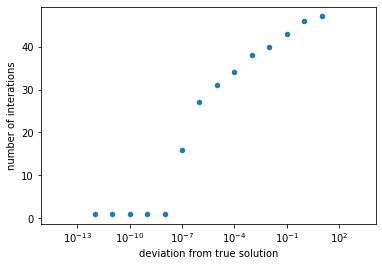

In [17]:
import numpy as np
import pandas as pd

m = sp.sparse(sp.random_banded(50, 3))
v = np.random.random(50)
sys = sp.linsys(m,v)

sol = np.array(sys.solve(method='scipy'))

factors = [10**i for i in range(-12, 2)]
data = []
for f in factors:
    s, i = sys.cg_solve(init_guess=sol * (f+1), return_iter=True)
    data.append((f, i))
df = pd.DataFrame(data, columns=['deviation from true solution', 'number of interations'])
df.plot.scatter('deviation from true solution', 'number of interations', logx=True)
plt.show()

***
## Input checking

The mathmatical operations each have certain requirements on the shape of the arguments.<br>
For Addition and Subtraction shapes need to be identical along both axes. `_vdot`, `_mdot` `_mdot_fast` require different axes to be the same.<br>
These checks are simmilar and should therefore be generelised to conform to DRY coding (**D**on't **R**epeat **Y**ourself).

For this purpose we have written the `shape_govenour` decorator which accepts axes along which the arguments must match.

Not providing `axes` results in the shape_govenour checking if both axes match, providing a `tuple` checks the provided axes. 

In [18]:
from inspect import getsource
print(getsource(sp.shape_govenour))

def shape_govenour(axis=None):
    # TODO Needs doc
    """
    Author: Simon Glennemeier-Marke
    """
    def middle(func):
        def check(obj1, obj2):
            if axis is None:
                if obj1.shape != obj2.shape:
                    raise ShapeError(
                        f"Objects of dissimilar dimension cannot be added")
                return func(obj1, obj2)

            assert (type(axis) == tuple) & (len(axis) == 2)
            axis1, axis2 = axis

            cond1 = (type(obj1) in [sparse, np.ndarray, scipy.sparse.spmatrix]) and (
                type(obj2) in [sparse, np.ndarray, scipy.sparse.spmatrix])
            if not cond1:
                raise ShapeError(
                    f"Objects passed to {func.__name__} of incompatible types")

            assert obj1.shape[axis1 - 1] == obj2.shape[axis2 - 1]
            return func(obj1, obj2)

        return check
    return middle



Since unlike usual decorators, this one can accept arguments.<br>
I would like to take some time and explain that a little bit:

Whenever we define a decorator without arguments, we construct a nested function of which the inner function returns the evaluated decorated function.

```python
def decorator(func):
    def wrapper(*args,**kwargs):
        # Wrapper code e.g.: Timing
        t1 = time()
        ret = func(args,kwargs)
        t2 = time()
        print(f"{func.__name__} took {t2-t1}s to complete.")
        return ret
    return wrapper

@decorator
def slow_code(x,y):
    sleep(1)

>>> slow_code()
slow_code took 1.0007219314575195s to complete.
```
Decorating a function essentially translates to: 

`slow_code = decorator(slow_code)`

The callable `slow_code` gets reassinged to the return of the `decorator` which is the inner wrapper function.<br>
So when we call `slow_code(x,y)` Python does this: `decorator(slow_code)(x,y)` which is `wrapper(x,y)` with `func=slow_code` as a variable.

> *Sidenote*: Notice here that `func` is not defined within `wrapper`, but since it isn't defined here, Python searches for it first in **L**ocal, then in 
**E**nclosing (where  it is found), then Python would search for it **G**lobal and finally in **B**uilt-In. <br>
This is known as the **LEGB rule for Python Scope**.

When we want to pass arguments to the decorator we have to introduce another function into the decorator.

```python
def decorator(deco_arg):
    def middle(func):
        def wrapper(*args,**kwargs):
            # Wrapper code e.g.: Timing
            t1 = time()
            print(deco_arg)
            ret = func(args,kwargs)
            t2 = time()
            print(f"{func.__name__} took {t2-t1}s to complete.")
            return ret
        return wrapper
    return middle

@decorator("I am a decorator argument")
def slow_code(x,y):
    sleep(1)

>>> slow_code()
I am a decorator argument
slow_code took 1.0011670589447021s to complete.
```

Again, Python decorates like this under the hood:

`slow_code=decorator(deco_arg)(slow_code)`

A function call `slow_code(x)` translates to `decorator(deco_arg)(slow_code)`. The decorator can now work with the `deco_arg`s and from now on `middle(slow_code)` is treated as the argumentless decorator we discussed before.

***
## Optimization

The following test was done using [line-profiler](https://pypi.org/project/line-profiler/) and we can see how much time each line takes to execute.<br>
This gives us the ability to spot inefficient code and work on faster methods.

```
Timer unit: 1e-06 s

Total time: 20.3556 s
File: libsparse.py
Function: _mdot at line 364

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
   366                                               def _mdot(self, other):
   367                                                   '''
   368                                                   Author: Simon Glennemeier-Marke
   369                                                   '''
   370         1         14.0     14.0      0.0          result = np.zeros((self.shape[0], other.shape[1]))
   371       101         47.0      0.5      0.0          for i in range(self.shape[0]):
   372     10100       5262.0      0.5      0.0              for j in range(other.shape[1]):
   373     10000    8486744.0    848.7     41.7                  row = self[i, None]
   374     10000    8553620.0    855.4     42.0                  col = other[None, j]
   375                                                           # result[i, j] = sum([r*c for r, c in zip(row, col)])
   376     10000       9128.0      0.9      0.0                  temp_result = 0
   377   1010000     468805.0      0.5      2.3                  for r, c in zip(row, col):
   378   1000000    2344940.0      2.3     11.5                      if r*c < np.finfo(np.float).eps:
   379    953287     424089.0      0.4      2.1                          continue
   380     46713      37779.0      0.8      0.2                      temp_result += r*c
   381     10000      15647.0      1.6      0.1                  result[i, j] = temp_result
   382         1        146.0    146.0      0.0          if np.alltrue(result == np.zeros_like(result)):
   383                                                       raise AllZeroError
   384                                                   else:
   385         1       9370.0   9370.0      0.0              return sparse(result)

Total time: 0.462044 s
File: libsparse.py
Function: _mdot_fast at line 387

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
   389                                               def _mdot_fast(self, other):
   390                                                   '''
   391                                                   Author: Henrik Spielvogel
   392                                                   '''
   393         1       8160.0   8160.0      1.8          other = other.transpose()
   394         1          3.0      3.0      0.0          n = self.N
   395         1          9.0      9.0      0.0          result = np.zeros((n, n))
   396       101         62.0      0.6      0.0          for i in range(n):
   397     10100       4501.0      0.4      1.0              for j in range(n):
   398     10000       7957.0      0.8      1.7                  slice_A = slice(self.CSR['IROW'][i], self.CSR['IROW'][i+1])
   399     10000       7080.0      0.7      1.5                  slice_B = slice(other.CSR['IROW'][j], other.CSR['IROW'][j+1])
   400                                           
   401     10000       6906.0      0.7      1.5                  row_val_A = self.CSR['AVAL'][slice_A]
   402     10000       6231.0      0.6      1.3                  col_n_A = self.CSR['JCOL'][slice_A]
   403                                           
   404     10000       7153.0      0.7      1.5                  row_val_B = other.CSR['AVAL'][slice_B]
   405     10000       6604.0      0.7      1.4                  col_n_B = other.CSR['JCOL'][slice_B]
   406                                           
   407    224600      95542.0      0.4     20.7                  for ind in col_n_A:
   408    214600     185908.0      0.9     40.2                      if ind in col_n_B:
   409     93426      85884.0      0.9     18.6                          result[i][j] += row_val_A[col_n_A.index(ind)] * \
   410     46713      36002.0      0.8      7.8                              row_val_B[col_n_B.index(ind)]
   411         1       4042.0   4042.0      0.9          return sparse(result)
```

As we can see in the header of each profiled function, the first method `_mdot` is ~40 times slower than `_mdot_fast` in computing a matrix product of two (100x100)-matrices.<br>
The reason for the speed up is mainly due to the inefficient use of `__getitem__` and `__setitem__`.
On thier own, these methods are sufficiently fast, but when used in a function which uses these n²-times they are very inefficient.

A more efficient way is to directly work with the storage scheme; as done in the `_mdot_fast`.
An attempt was made to improve `__getitem__` and `__setitem__`. However we were unable to achieve a significant improvement.

One approach was done using caching or memoization. By using the `@memoize` decorator, it is checked wether the function has already been evaluated with the given arguments. If this is the case, the previous value is returned without calling the function. If the arguments do not match previous function calls, the function is evaluated and its output is stored in a dictionary with the arguments as the key.

Although this would in theory speed up the calculations, it significantly slowed them down. The reason is again the enormous number of calls to the decorator and the time gained by cached value is not sufficient to nullify the time penalty.

Therefore it has to be considered if the time penalty constitutes the logical simplicity. In our opinion it clearly did not, hence to keep performance high the default behaviour is the `_mdot_fast` method.



These optimization studys were done for a number of methods included in `libsparse.py`. <br> We will not discuss them here any further as the strategys for improvement are analogous and less interesting (such as using `numpy.ndarray`s instead of built-in `list`s).